# 2.1 Transit light curve analysis of WASP-12b 

### Universidad de La Laguna Exo & Exo 2022 exercise 2

Author: [Hannu Parviainen](mailto:hannu@iac.es)<br>
Last updated: 1.5.2022

## Initialisation

In [1]:
%matplotlib inline 

In [2]:
import math as mt
import pandas as pd
import warnings
import seaborn as sb

from matplotlib.pyplot import subplots, setp, rc, Rectangle
from numpy import argmax, array, median, seterr, floor, percentile
from numpy.random import seed, permutation
from astropy.table import Table
from corner import corner

from pytransit import TransitLPF

seterr('ignore')
seed(0)

### Read in the data

First we need to read in the light curve stored in ``wasp-12b_181227_chromatic_k.fits``. The file has light curves for a single transit observed simultaneously in four passbands (g, r, i, and z_s), but we keep things simple and use only the r-band data. 

In our case, the photometry is saved as binary table extensions in the fits file, one extension per passband. To get the r-band data, we need to read the third HDU of the fits file (the first is the primary HDU, the second the first extension, etc.).

We start the same way as with the RV data and take a look at our data and try plotting it.

In [3]:
tb = Table.read('data/wasp-12b_181227_chromatic_k.fits', 2)
tb[:5]

time_bjd,flux,flux_rel,flux_trg,flux_ref,baseline,model
float64,float64,float64,float64,float64,float64,float64
2458480.557361179,1.0001350941062013,1.016282780690799,1.0234186998514527,1.0070215881802143,1.0161455054219737,1.0
2458480.558397079,1.0000222850175708,1.0167163747091499,1.0256873377854854,1.0088234667007323,1.0166937176717874,1.0
2458480.5587828704,0.999633046547194,1.0162828378132795,1.0244264276468822,1.0080131136044028,1.016655903207277,1.0
2458480.5594445122,1.0004227218395325,1.0169303171289636,1.0232086525273774,1.0061738108232814,1.016500620116942,1.0
2458480.5602084063,0.9981259684100012,1.0146302762017558,1.021813766379826,1.0070799091516973,1.0165352954577924,1.0


Now, we can assume the time data is stored in the ``time_bjd`` column and the flux the ``flux`` column. In general, if you'd see a file like this, you should check the file's documentation (if such exists) what column is what, or ask the person who created the file.

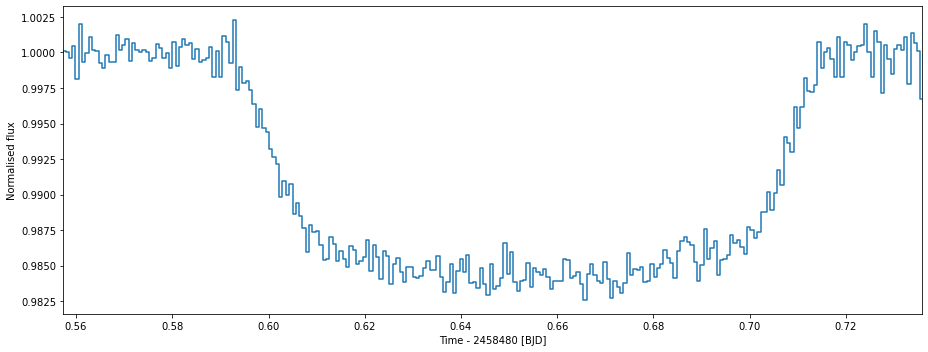

In [4]:
tref = floor(tb['time_bjd'].mean())
fig, ax = subplots(figsize=(13,5), sharey=True)
ax.plot(tb['time_bjd'] - tref, tb['flux'], drawstyle='steps-mid')
setp(ax, xlabel=f"Time - {tref:.0f} [BJD]", ylabel='Normalised flux', xlim=tb['time_bjd'][[0,-1]]-tref)
fig.tight_layout()

## Parameter estimation

First, we create an instance of the log posterior function with the redmost light curve data.

Next, we run the *DE* optimiser for ``de_iter`` iterations to clump the parameter vector population close to the global posterior maximum, use the *DE* population to initialise the *emcee* sampler, and run the sampler for ``mc_iter`` iterations to obtain a posterior sample.

### Initialise the LPF and set the priors

In [5]:
lpf = TransitLPF('WASP-12b', 'r', tb['time_bjd'], tb['flux'])
lpf.ps

[  0 |G| tc             N(μ = 0.0, σ = 0.1)                      [    -inf ..      inf],
   1 |G| p              N(μ = 1.0, σ = 1e-05)                    [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

tc = transit center

p = orbital period (like in the rv)

rho = stellar density, g/c^3, it affects the orbital velocity of the planet and therefore the transit duration

b = related to inclination

k2 = area ratio: planet area / star area

q1r, q2r = limb darkening parameters

wn_loge_0 = white noise parameter

To obtain the major axis we use Kepler laws, knowing p, b, and maybe others?

In [6]:
#we set some of the priors
lpf.set_prior('tc', 'NP', 2458480.65, 0.02)
lpf.set_prior('p', 'NP', 1.0914201, 1.1e-09)

In [7]:
lpf.ps

[  0 |G| tc             N(μ = 2458480.65, σ = 0.02)              [    -inf ..      inf],
   1 |G| p              N(μ = 1.0914201, σ = 1.1e-09)            [    0.00 ..      inf],
   2 |G| rho            U(a = 0.1, b = 25.0)                     [    0.00 ..      inf],
   3 |G| b              U(a = 0.0, b = 1.0)                      [    0.00 ..     1.00],
   4 |P| k2             U(a = 0.0025, b = 0.04)                  [    0.00 ..      inf],
   5 |P| q1_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   6 |P| q2_r           U(a = 0, b = 1)                          [    0.00 ..     1.00],
   7 |L| wn_loge_0      U(a = -4, b = 0)                         [    -inf ..      inf]]

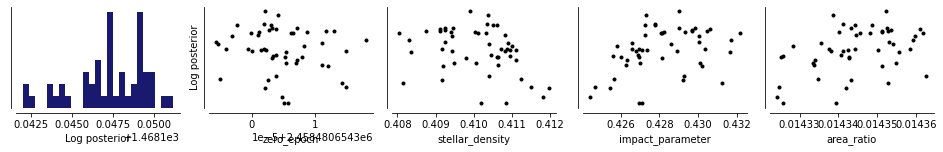

In [8]:
lpf.optimize_global(niter=500, npop=50) #optimize the models

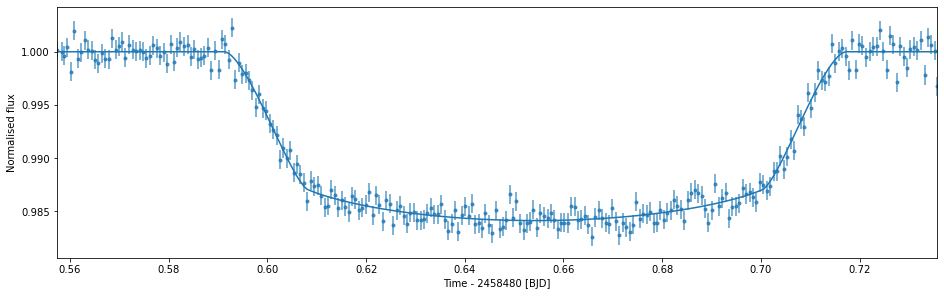

In [9]:
lpf.plot_light_curve();

In [10]:
lpf.sample_mcmc(5000, thin=20, repeats=2, label='MCMC sampling')

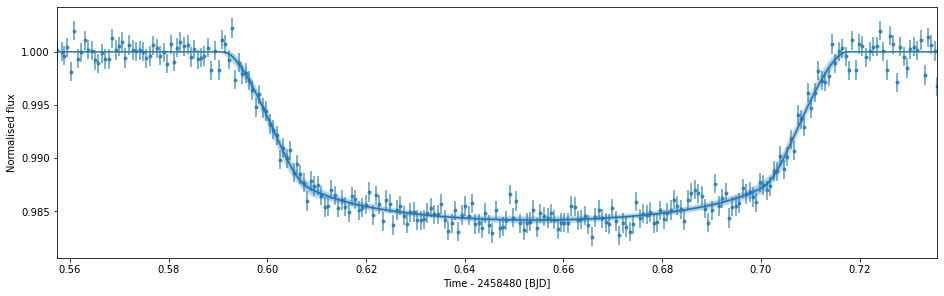

In [11]:
lpf.plot_light_curve('mc');

### Analysis: overview

The MCMC chains are now stored in ``lpf.sampler.chain``. Let's first have a look into how the chain populations evolved to see if we have any problems with our setup, whether we have converged to sample the true posterior distribution, and, if so, what was the burn-in time.

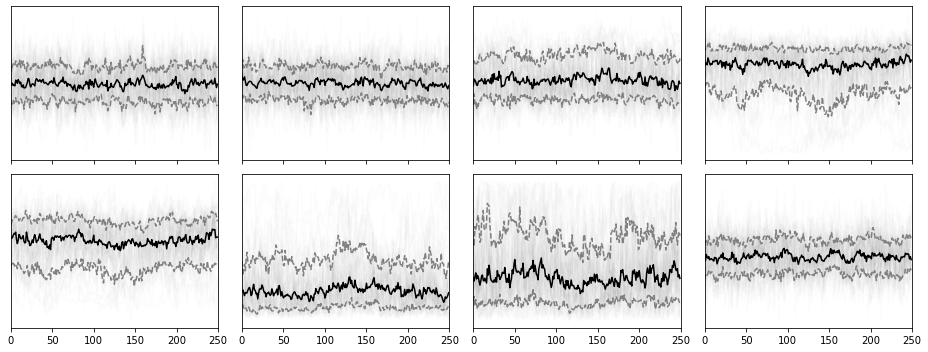

In [12]:
fig, axs = subplots(2,4, figsize=(13,5), sharex=True)
ls, lc = ['-','--','--'], ['k', '0.5', '0.5']
percs = [percentile(lpf.sampler.chain[:,:,i], [50,16,84], 0) for i in range(8)]
[axs.flat[i].plot(lpf.sampler.chain[:,:,i].T, 'k', alpha=0.01) for i in range(8)]
[[axs.flat[i].plot(percs[i][j], c=lc[j], ls=ls[j]) for j in range(3)] for i in range(8)]
setp(axs, yticks=[], xlim=[0,5000//20])
fig.tight_layout()

Ok, everything looks good. The 16th, 50th and 84th percentiles of the parameter vector population are stable and don't show any significant long-term trends. Now we can flatten the individual chains into one long chain ``fc`` and calculate the median parameter vector.

In [13]:
fc = lpf.sampler.chain.reshape([-1,lpf.sampler.chain.shape[-1]])
mp = median(fc, 0)

Let's also plot the model and the data to see if this all makes sense. To do this, we calculate the conditional distribution of flux using the posterior samples (here, we're using a random subset of samples, although this isn't really necessary), and plot the distribution median and it's median-centred 68%, 95%, and 99.7% central posterior intervals (corresponding approximately to 1, 2, and 3$\sigma$ intervals if the distribution is normal). 

In [14]:
flux_pr = lpf.flux_model(fc[permutation(fc.shape[0])[:1000]])
flux_pc = array(percentile(flux_pr, [50, 0.15,99.85, 2.5,97.5, 16,84], 0))

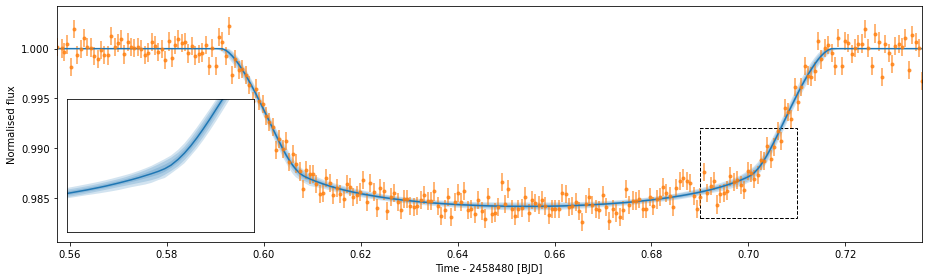

In [15]:
zx1,zx2,zy1,zy2 = 0.69,0.71, 0.983, 0.992
tref = floor(lpf.timea.min())
fig, ax = subplots(1,1, figsize=(13,4))
ax.errorbar(lpf.timea-tref, lpf.ofluxa, 10**mp[7], fmt='.', c='C1', alpha=0.75)
[ax.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
ax.plot(lpf.timea-tref, flux_pc[0], c='C0')
setp(ax, xlim=lpf.timea[[0,-1]]-tref, xlabel=f'Time - {tref:.0f} [BJD]', ylabel='Normalised flux')
fig.tight_layout()

az = fig.add_axes([0.075,0.18,0.20,0.46])
ax.add_patch(Rectangle((zx1,zy1),zx2-zx1,zy2-zy1,fill=False,edgecolor='k',lw=1,ls='dashed'))
[az.fill_between(lpf.timea-tref,*flux_pc[i:i+2,:],alpha=0.2,facecolor='C0') for i in range(1,6,2)]
setp(az, xlim=(zx1,zx2), ylim=(zy1,zy2), yticks=[], xticks=[])
az.plot(lpf.timea-tref, flux_pc[0], c='C0');

We could (should) also plot the residuals, but I've left them out from the plot for clarity. The plot looks fine, and we can continue to have a look at the parameter estimates.

## Analysis

We start the analysis by making a Pandas data frame ``df``, using the ``df.describe`` to gen an overview of the estimates, and plotting the posteriors for the most interesting parameters as violin plots.

In [16]:
pd.set_option('display.precision',4)
df = lpf.posterior_samples(derived_parameters=True)
df.describe()

,tc,p,rho,b,k2,q1_r,q2_r,wn_loge_0,k,a,inc,t14,t23
count,1.2500e+04,1.2500e+04,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000,12500.0000
mean,2.4585e+06,1.0914e+00,0.4318,0.3511,0.0140,0.2957,0.3600,-3.0407,0.1183,3.0050,1.4527,0.1257,0.0943
std,1.6099e-04,1.0852e-09,0.0341,0.1078,0.0004,0.1842,0.2401,0.0196,0.0018,0.0791,0.0384,0.0009,0.0024
min,2.4585e+06,1.0914e+00,0.3139,0.0002,0.0127,0.0442,0.0002,-3.1104,0.1126,2.7040,1.3489,0.1225,0.0857
25%,2.4585e+06,1.0914e+00,0.4062,0.2954,0.0137,0.1576,0.1709,-3.0539,0.1172,2.9464,1.4246,0.1251,0.0925
50%,2.4585e+06,1.0914e+00,0.4288,0.3785,0.0141,0.2456,0.3072,-3.0409,0.1186,3.0002,1.4444,0.1257,0.0941
75%,2.4585e+06,1.0914e+00,0.4568,0.4295,0.0143,0.3828,0.5055,-3.0278,0.1197,3.0640,1.4742,0.1264,0.0960
max,2.4585e+06,1.0914e+00,0.5340,0.5951,0.0151,0.9994,0.9999,-2.9583,0.1228,3.2278,1.5707,0.1307,0.1009


<AxesSubplot:>

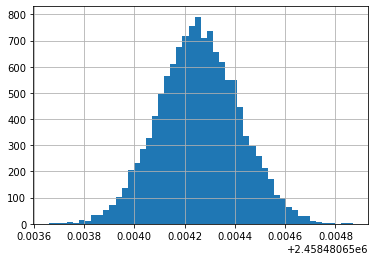

In [17]:
df.tc.hist(bins=50)

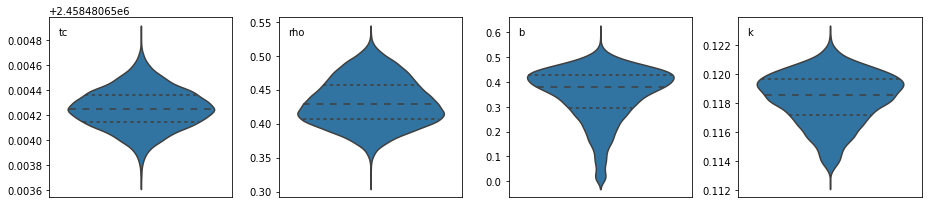

In [18]:
fig, axs = subplots(1,4, figsize=(13,3))
pars = 'tc rho b k'.split()
[sb.violinplot(y=df[p], inner='quartile', ax=axs.flat[i]) for i,p in enumerate(pars)]
[axs.flat[i].text(0.05,0.9, p, transform=axs.flat[i].transAxes) for i,p in enumerate(pars)]
setp(axs, xticks=[], ylabel='')
fig.tight_layout()

While we're at it, let's plot some correlation plots. The limb darkening coefficients are correlated, and we'd also expect to see a correlation between the impact parameter and radius ratio.

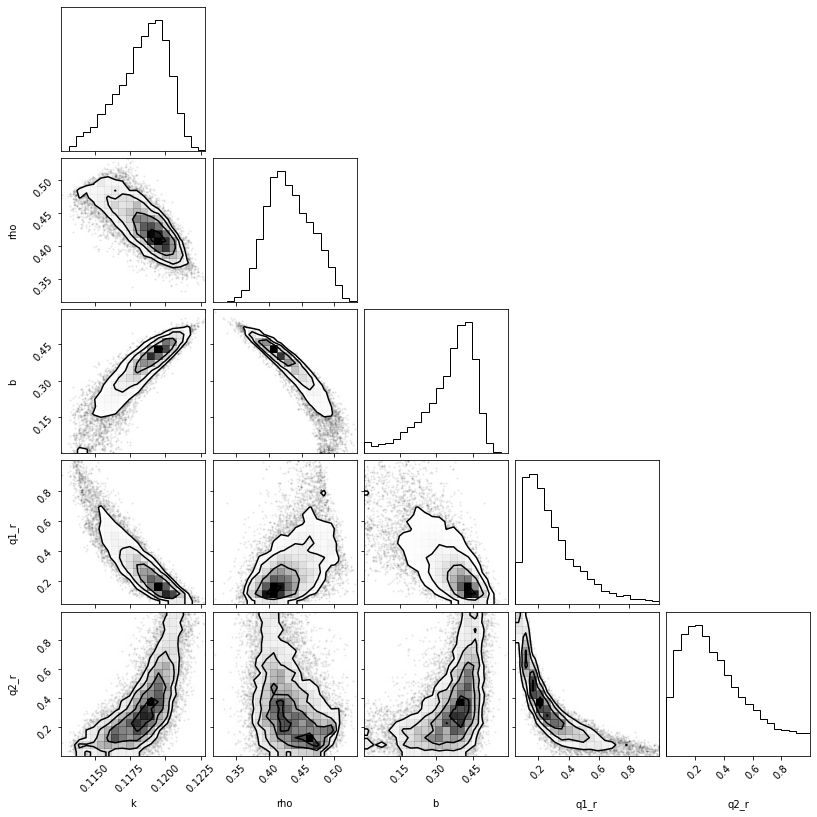

In [19]:
ccols = ['k', 'rho', 'b', 'q1_r', 'q2_r']
corner(df[ccols], labels=ccols);

Here the posteriors aren't as normal as in the rv analysis. The marginal posterior distributions are not as normal as we'd like, and there are many correlations between all of the parameters. 

### <span style="color:darkblue">Questions and exercises</span>

1. Estimate the radius of the planet using the planet-star radius ratio (k) and the stellar radius (that you need to find from somewhere ;)) Give the answer in Jupiter radii.

$$\frac{R_P}{R_J}=k \frac{R_{star}}{R_\odot} \frac{R_\odot}{R_J}$$

In [20]:
import numpy as np
k_mean=np.median(df.k)

Rjup=69911 #km
Rsun=696340 #km
Rstar=1.657 #solar radius

Rp=k_mean*Rstar*Rsun/Rjup
print('The planet radius is',Rp,'Jupiter radii')

The planet radius is 1.9574516225828131 Jupiter radii


2. Compare the stellar density ($\rho$) estimated from the transit modelling to the theoretical stellar density for a WASP-12-like star.

In [21]:
rho_med=np.median(df.rho)

Mstar=1.35 #in solar masses
Rstar=1.57 #in solar radii
Rsun=696340e5 #cm
Msun=1.9891e33 #g

rho_th=Mstar*Msun/(4/3*np.pi*(Rstar*Rsun)**3)

print('Estimated density in g/cm^3 = ', rho_med)
print('Theoretical density in g/cm^3 = ', rho_th)

Estimated density in g/cm^3 =  0.42883209066680655
Theoretical density in g/cm^3 =  0.4906127042010381


3. From the plot above you can see that many of the parameters are correlated with each other. What does this mean in practice?

- Many parameters are correlated with each other. This means that if one of the parameters changes a little bit, the others will change a lot, too. Therefore, the fit is not very exact, because the value of each parameter depends a lot on all the others. 

**REFERENCES**

The masses and radii for WASP-12 are from the following paper:

[Hebb, L et al. (2009). WASP-12b: The Hottest Transiting Extrasolar Planet Yet Discovered. The Astrophysical Journal, 693:1920–1928](https://ui.adsabs.harvard.edu/abs/2009ApJ...693.1920H/abstract)

---
<center>&copy; Hannu Parviainen 2014&ndash;2022</center>